#### For a given query, q, we calculate its corresponding AP, and then the mean of the all these AP scores would give us a single number, called the mAP, which quantifies how good our model is at performing the query.
#### It uses Intersection over Union(IoU), Precision and Recall values. 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
rc('font', **font)
%matplotlib inline

<img src="iou.png" title = "IoU"/>

In [27]:
def intersection_over_union(boxA, boxB):
    """
    Finds the intersection over union between boxes boxA and boxB
    Parameters
    ---------------------------------------------------------------------------
    boxA: list of 4 coordinates of bounding boxA x1,y1,x2,y2
    boxB: list of 4 coordinates of bounding boxB x1, y1, x2, y2
    Returns
    ---------------------------------------------------------------------------
    Intersection over union of two bounding boxes
    """
    xA = np.maximum(boxA[:,0], boxB[:,0])
    yA = np.maximum(boxA[:,1], boxB[:,1])
    xB = np.minimum(boxA[:,2], boxB[:,2])
    yB = np.minimum(boxA[:,3], boxB[:,3])

    interArea = np.maximum(0, xB - xA ) * np.maximum(0, yB - yA )
    boxAArea = (boxA[:,2] - boxA[:,0] ) * (boxA[:,3] - boxA[:,1] )
    boxBArea = (boxB[:,2] - boxB[:,0]) * (boxB[:,3] - boxB[:,1])
    iou = interArea / (boxAArea + boxBArea - interArea)
    return np.reshape(iou,(-1,1))

In [28]:
def get_max_overlap_idx(boxA,boxB):
    n_gnd = boxA.shape[0]
    n_pred = boxB.shape[0]
    box1 = np.reshape(boxA,(-1,1,4))
    box1 = np.tile(box1,(1,n_pred,1))
    box2 = np.reshape(boxB,(-1,n_pred,4))
    box2 = np.tile(box2,(n_gnd,1,1))
    box1 = np.reshape(box1,(-1,4))
    box2 = np.reshape(box2,(-1,4))
    iou = intersection_over_union(box1,box2)
    iou = np.reshape(iou,(-1,n_pred))
    max_overlap_idx = np.argmax(iou,axis=1)
    return max_overlap_idx

In [51]:
IOU_THRESH = 0.5
def match_gnd_with_pred(gnd_box,pred_box):
    boxA = gnd_box
    boxB = pred_box
    n_gnd = boxA.shape[0]
    n_pred = boxB.shape[0]
    max_overlap_idx = get_max_overlap_idx(boxA,boxB)
    max_overlap_idx2 = get_max_overlap_idx(boxB,boxA)
    matched_boxes = []
    for i in range(n_gnd):
        j = max_overlap_idx[i]
        k = max_overlap_idx2[j]
        iou  = intersection_over_union(boxA[i].reshape((-1,4)),boxB[j].reshape((-1,4)))
        if i == k and iou >= 0.5:
            matched_boxes.append([i,j])
    matched_boxes = np.array(matched_boxes)
    return matched_boxes

In [52]:
def confusion_matrix(gnd,pred):
    n_gnd = gnd.shape[0]
    label_idx = {
    'infected': 0,
    'not_infected': 1,
    'no_obj': 3
    }
    confusion_matrix = np.zeros(shape=(3,3))
    #If no predictions are made for ground truth
    if pred is None:
        for i in range(n_gnd):
            box_gnd = gnd.iloc[i]
            label_i = label_idx[box_gnd['label']]
            confusion_matrix[label_i,2] = confusion_matrix[label_i,2]+1
        return np.array(confusion_matrix)
            
    n_pred = pred.shape[0]
    boxA = np.array(gnd[['xmin','ymin','xmax','ymax']])
    boxB = np.array(pred[['xmin','ymin','xmax','ymax']])
    matched_boxes = match_gnd_with_pred(boxA,boxB)
    #if no match is found
    if(matched_boxes.shape[0] == 0):
        for i in range(n_gnd):
            box_gnd = gnd.iloc[i]
            label_i = label_idx[box_gnd['label']]
            confusion_matrix[label_i,2] = confusion_matrix[label_i,2]+1
            
        for i in range(n_pred):
            box = pred.iloc[i]
            idx = label_idx[box['label']]
            confusion_matrix[2,idx] = confusion_matrix[2,idx]+1
        return np.array(confusion_matrix)
    
    
    matched_gnd = matched_boxes[:,0]
    matched_preds = matched_boxes[:,1]


    for i in range(n_pred):
        if i not in matched_preds:
            box = pred.iloc[i]
            idx = label_idx[box['label']]
            confusion_matrix[2,idx] = confusion_matrix[2,idx]+1
        else:
            box = pred.iloc[i]
            idx = np.argwhere(matched_preds==i).flatten()[0]
            gnd_idx = matched_boxes[idx,0]
            box_gnd = gnd.iloc[gnd_idx]
            label_i = label_idx[box_gnd['label']]
            label_j = label_idx[box['label']]
            confusion_matrix[label_i,label_j] = confusion_matrix[label_i,label_j]+1

    for i in range(n_gnd):
        if i not in matched_gnd:
            box_gnd = gnd.iloc[i]
            label_i = label_idx[box_gnd['label']]
            confusion_matrix[label_i,2] = confusion_matrix[label_i,2]+1
    return np.array(confusion_matrix)


#### True Positive (IoU > 0.5)
#### False Positive - There are two possible scenarios where a BB would be considered as FP: IoU <0.5 or duplicated bounding box
#### False Negative - When the predicted BB has an IoU > 0.5 but has the wrong classification, the predicted BB would be FN.

In [ ]:
def asssign_label(gnd,pred):
#     label_idx = {
#     'infected': 0,
#     'not_infected': 1,
#     }

    n_gnd = gnd.shape[0]
    n_pred = pred.shape[0]
    labels = []
    boxA = np.array(gnd[['xmin','ymin','xmax','ymax']])
    boxB = np.array(pred[['xmin','ymin','xmax','ymax']])
    matched_boxes = match_gnd_with_pred(boxA,boxB)
    
    if(matched_boxes.shape[0] == 0):
        for i in range(n_pred):
            labels.append('FP')
        return labels
    
    matched_gnd = matched_boxes[:,0]
    matched_preds = matched_boxes[:,1]
    
    for i in range(n_pred):
        if i in matched_preds:
            pred_label = pred.iloc[i]['label']
            idx = np.argwhere(matched_preds == i).flatten()[0]
            gnd_box = gnd.iloc[matched_gnd[idx]]
            gnd_label = gnd_box['label']
            if pred_label == gnd_label:
                labels.append('TP')
            else:
                labels.append('FN')
        else:
            labels.append('FP')
    return labels

#### Precision = TP/(TP+FP)

In [32]:
def calculate_precision(labels):
    tp = 0
    fp = 0
    fn = 0
    result = []
    for i in labels:
        if i == 'TP':
            tp+=1
        elif i == 'FP':
            fp+=1
        elif i == 'FN':
            pass
        else:
            return 'Undefined Label'
        precision = tp / float(tp+fp)
        result.append(precision)
    return np.array(result)

#### Recall = TP/(TP+FN)

In [33]:
def calculate_recall(labels,total_samples):
    tp = 0
    fp = 0
    fn = 0
    result = []
    for i in labels:
        if i == 'TP':
            tp+=1
        elif i == 'FP':
            pass
        elif i == 'FN':
            fn+=1
        else:
            return 'Undefined Label'
        recall = tp / float(total_samples)
        result.append(recall)
    return np.array(result)


In [54]:
def calculate_interpolated_precision(precision,recall):
    interpolated_pr = []
    for r in recall:
        p = []
        for i in range(recall.shape[0]):
            r_hat = recall[i]
            if r_hat >= r:
                p.append(precision[i])
        p = np.array(p)
        interpolated_pr.append(np.max(p))
    return np.array(interpolated_pr)

In [55]:
# gnd_truth_file = 'map/leaf_data_v2/test_gnd_truth.csv'
# pred_file = 'map/leaf_data_v2/test_pred.csv'
gnd_truth_file = 'test_gnd_truth.csv'
pred_file = 'test_pred.csv'

In [56]:
gnd_truth_df =  pd.read_csv(gnd_truth_file)
pred_df = pd.read_csv(pred_file)

In [57]:
gnd_truth_df.head(5)

,filename,label,xmin,ymin,xmax,ymax
0,0,infected,0.765159,0.454003,1.000000,0.739817
1,0,infected,0.717118,0.809340,0.793843,1.000000
2,0,infected,0.098647,0.524228,0.188433,0.768961
3,0,infected,0.001866,0.146419,0.154618,0.496489
4,0,infected,0.001866,0.124298,0.363106,0.448736


In [58]:
pred_df.head(5)

,filename,label,xmin,ymin,xmax,ymax,objectness
0,0,infected,0.087316,0.253710,0.219692,0.515210,0.470987
1,0,infected,0.191974,0.488370,0.306715,0.605475,0.415043
2,0,infected,0.108109,0.291362,0.190833,0.464478,0.378743
3,0,infected,0.283426,0.071166,0.366332,0.232455,0.377522
4,0,infected,0.195996,0.396782,0.303242,0.670297,0.293125


In [59]:
pred_file_groups = pred_df.groupby('filename').groups

In [60]:
#For infected
gnd_truth_df = gnd_truth_df[gnd_truth_df['label'] == 'infected'].reset_index(drop=True)
print(gnd_truth_df)
n_infected = gnd_truth_df.shape[0]
gnd_file_groups = gnd_truth_df.groupby('filename').groups
labels = []
infected_pred = pd.DataFrame(columns=['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax', 'objectness'])
#Label all the predictions(TP,FP,FN)
for i,j in gnd_file_groups.items():
    if i not in pred_file_groups.keys():
        continue
    gnd = gnd_truth_df.iloc[j].reset_index(drop=True)
    pred = pred_df.iloc[pred_file_groups[i]].reset_index(drop=True)
    labels+=asssign_label(gnd,pred)
    infected_pred = infected_pred.append(pred).reset_index(drop=True)
infected_pred['label'] = labels
infected_pred = infected_pred.sort_values('objectness',ascending=False).reset_index(drop=True)
labels = infected_pred['label']
precision = calculate_precision(labels)
recall = calculate_recall(labels,n_infected)
interpo_pr = calculate_interpolated_precision(precision,recall)

infected_recall = recall
infected_precision = interpo_pr

     filename     label      xmin      ymin      xmax      ymax
0           0  infected  0.765159  0.454003  1.000000  0.739817
1           0  infected  0.717118  0.809340  0.793843  1.000000
2           0  infected  0.098647  0.524228  0.188433  0.768961
3           0  infected  0.001866  0.146419  0.154618  0.496489
4           0  infected  0.001866  0.124298  0.363106  0.448736
5           0  infected  0.418144  0.349719  0.536847  0.682935
6           0  infected  0.605410  0.365871  0.751632  0.683989
7           0  infected  0.440065  0.000702  0.679571  0.252809
8           0  infected  0.387127  0.065309  0.464785  0.165379
9           0  infected  0.208955  0.502809  0.471082  0.718048
10          0  infected  0.190765  0.708216  0.476912  0.900632
11          1  infected  0.439063  0.255556  0.603646  0.406481
12          1  infected  0.753646  0.287037  1.000000  0.781481
13          1  infected  0.464583  0.725926  0.881250  1.000000
14          1  infected  0.045833  0.476

In [61]:
infected_pred['precision'] = precision
infected_pred['recall'] = recall
infected_pred['interpo_pr'] = interpo_pr

In [62]:
infected_pred.head(10)

,filename,label,xmin,ymin,xmax,ymax,objectness,precision,recall,interpo_pr
0,2,TP,0.606893,0.149920,1.000000,0.549066,0.878107,1.000000,0.003460,1.000000
1,3,TP,0.586051,0.157897,1.000000,0.537201,0.869393,1.000000,0.006920,1.000000
2,3,FP,0.371538,0.574787,0.439813,0.691978,0.852274,0.666667,0.006920,1.000000
3,2,FP,0.359104,0.581248,0.439213,0.671105,0.841211,0.500000,0.006920,1.000000
4,2,TP,0.582630,0.646069,0.698273,0.780115,0.838463,0.600000,0.010381,0.611111
5,36,FP,0.612776,0.441205,0.697597,0.557697,0.829037,0.500000,0.010381,0.611111
6,3,FP,0.427688,0.820252,0.587430,1.000000,0.825428,0.428571,0.010381,0.611111
7,2,TP,0.565476,0.148970,0.646438,0.253471,0.822767,0.500000,0.013841,0.611111
8,2,TP,0.369966,0.035116,0.453107,0.167467,0.798619,0.555556,0.017301,0.611111
9,36,FP,0.510408,0.804278,0.620837,0.934477,0.781439,0.500000,0.017301,0.611111


#### Precision vs Interpolated Precision and area under the graph

D:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


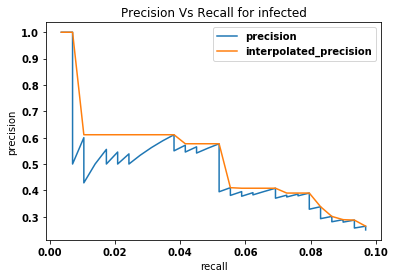

In [63]:
plt.xlabel('recall',)
plt.ylabel('precision')
plt.title('Precision Vs Recall for infected')
plt.plot(recall,precision,label='precision')
plt.plot(recall,interpo_pr,label='interpolated_precision')
plt.legend()

In [64]:
sampled_recall = np.linspace(0,1.0,11)
sampled_precision = calculate_interpolated_precision(precision,sampled_recall)
mAP_infected = np.average(sampled_precision)
print('mAP For Infected = ',mAP_infected )

mAP For Infected =  0.6527089072543617


In [65]:
#For not_infected
gnd_truth_df =  pd.read_csv(gnd_truth_file)
pred_df = pd.read_csv(pred_file)
pred_file_groups = pred_df.groupby('filename').groups
gnd_truth_df = gnd_truth_df[gnd_truth_df['label'] == 'not_infected'].reset_index(drop=True)
n_infected = gnd_truth_df.shape[0]
gnd_file_groups = gnd_truth_df.groupby('filename').groups
labels = []
infected_pred = pd.DataFrame(columns=['filename', 'label', 'xmin', 'ymin', 'xmax', 'ymax', 'objectness'])
#Label all the predictions(TP,FP,FN)
for i,j in gnd_file_groups.items():
    if i not in pred_file_groups.keys():
        continue
    gnd = gnd_truth_df.iloc[j].reset_index(drop=True)
    pred = pred_df.iloc[pred_file_groups[i]].reset_index(drop=True)
    labels+=asssign_label(gnd,pred)
    infected_pred = infected_pred.append(pred).reset_index(drop=True)
infected_pred['label'] = labels
infected_pred = infected_pred.sort_values('objectness',ascending=False).reset_index(drop=True)
labels = infected_pred['label']
precision = calculate_precision(labels)
recall = calculate_recall(labels,n_infected)
interpo_pr = calculate_interpolated_precision(precision,recall)

not_infected_recall = recall
not_infected_precision = interpo_pr

D:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


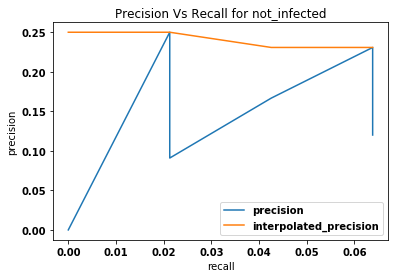

In [66]:
plt.xlabel('recall',)
plt.ylabel('precision')
plt.title('Precision Vs Recall for not_infected')
plt.plot(recall,precision,label='precision')
plt.plot(recall,interpo_pr,label='interpolated_precision')
plt.legend()
plt.show()

In [67]:
sampled_recall = np.linspace(0.0,0.9,11)
sampled_precision = calculate_interpolated_precision(precision,sampled_recall)
mAP_not_infected = np.average(sampled_precision)
print('mAP For no_infected = ',mAP_not_infected )

mAP For no_infected =  0.17604945559491014


#### Total mAP

In [68]:
mAP = (mAP_infected + mAP_not_infected) / 2

In [69]:
print('mAp = ',mAP )

mAp =  0.4143791814246359


D:\Anaconda\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


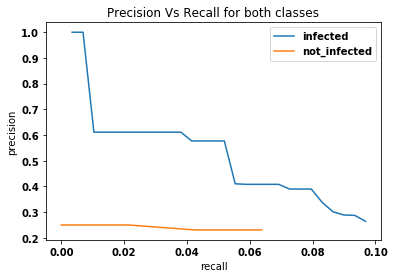

In [70]:
plt.xlabel('recall',)
plt.ylabel('precision')
plt.title('Precision Vs Recall for both classes')
plt.plot(infected_recall,infected_precision,label='infected')
plt.plot(not_infected_recall,not_infected_precision,label='not_infected')
plt.legend()
plt.show()